# Implémenter Transformers IDS



In [1]:
!pip install tokenizers
!pip install -q tensorflow_datasets
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tokenizers import BertWordPieceTokenizer
from tokenizers import Tokenizer
from tokenizers.models import BPE
import json
import time

     |████████████████████████████████| 3.3 MB 16.7 MB/s 



## Dataset creation



In [2]:
# Pre-processing
# Ajouter la longueur
# ajouter la possibilité de jouer avec plusieurs .csv et donc plusieurs datasets

dataset_path = "./Dataset_final.csv"
types_dataset = [str(), str(), str(), str(), str()]


dataset = tf.data.experimental.CsvDataset(dataset_path, record_defaults=types_dataset, header=True)

for example in dataset.take(5):
  print([e.numpy() for e in example])



#dataset = ["192.168.1.1", "3000", "192.168.2.3:30", "3500", "TCP"]

def concat_packet(packet):
    return ' '.join(packet)


#print(concat_packet(dataset))

[b'172.16.0.5', b'58445', b'192.168.50.1', b'4463', b'17']
[b'172.16.0.5', b'36908', b'192.168.50.1', b'9914', b'17']
[b'172.16.0.5', b'41727', b'192.168.50.1', b'32361', b'17']
[b'172.16.0.5', b'55447', b'192.168.50.1', b'5691', b'17']
[b'172.16.0.5', b'58794', b'192.168.50.1', b'56335', b'17']


# Preprocessing

## PacketTokenizer

In [3]:

#Entraîner avec START, END


class PacketTokenizer():
  def __init__(self, path_to_vocab):
    self._vocab = path_to_vocab
    self._tokenizer = Tokenizer.from_file(self._vocab)


  def train(self, files):
    self._tokenizer.train(
                    files,
                    vocab_size=100,
                    min_frequency=2,
                    show_progress=True,
                    special_tokens=['[START]', '[END]', '[PAD]', '[UNK]', '[CLS]', '[SEP]', '[MASK]'],
                    limit_alphabet=1000,
                    wordpieces_prefix="##"
                  )

  def tokenize(self, msg):
    token = self._tokenizer.encode("[START] " + str(msg) + " [END]")
    return token

  def detokenize(self, tokens):
    return self._tokenize.decode(tokens.ids)

  def get_vocab_path(self):
    return self._tokenizer

  def get_vocab_size(self):
    return self._tokenizer.get_vocab_size()
  
  def vocab(self):
    try:
      with open(f"{self._vocab}", "r") as vocab:
        data = json.load(vocab)
      print(data)
    except Exception:
      print("No Vocab file accessible")
    return data
  
  def lookup(self, packet):
    return tf.ragged.constant(self.tokenize(concat_packet(packet)).tokens)

  def tokenizer(self):
    pass

data = ["192.168.1.1", "3000", "192.168.2.3", "3500", "17"]
packetTokenizer = PacketTokenizer("./my-tokenizer.json")
packetTokenizer.vocab()
print(packetTokenizer.tokenize(concat_packet(data)).tokens)

packetTokenizer.lookup(concat_packet(data))

{'version': '1.0', 'truncation': None, 'padding': None, 'added_tokens': [{'id': 0, 'special': True, 'content': '[START]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}, {'id': 1, 'special': True, 'content': '[END]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}, {'id': 2, 'special': True, 'content': '[PAD]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}, {'id': 3, 'special': True, 'content': '[UNK]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}, {'id': 4, 'special': True, 'content': '[CLS]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}, {'id': 5, 'special': True, 'content': '[SEP]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}, {'id': 6, 'special': True, 'content': '[MASK]', 'single_word': False, 'lstrip': False, 'rstrip': False, 'normalized': False}], 'normalizer': {'type': 'BertNormalizer', 'clean_

<tf.Tensor: shape=(34,), dtype=string, numpy=
array([b'[START]', b'1', b'9', b'2', b'.', b'1', b'6', b'8', b'.', b'1',
       b'.', b'1', b'3', b'0', b'0', b'0', b'1', b'9', b'2', b'.', b'1',
       b'6', b'8', b'.', b'2', b'.', b'3', b'3', b'5', b'0', b'0', b'1',
       b'7', b'[END]'], dtype=object)>

# Pipepline

In [4]:
BUFFER_SIZE = 20000 #Nombre de paquets pris en compte avant la prédiction
BATCH_SIZE = 64 #Nombre de paquets rajoutés à chque tour
 
print(dataset.take(1))

def tokenize_pairs(tokens):
    tokens = tokens.to_tensor()
    tokens = PacketTokenizer.tokenize(tokens)
    tokens = tokens.to_tensor()
    # Convert from ragged to dense, padding with zeros.

def make_batches(ds):
  ds = ds.map(lambda *x: tf.convert_to_tensor(x))
  ds.batch(BATCH_SIZE)  
  return ds

#TODO: créer tf.data.Dataset


train_batches = make_batches(dataset)
val_batches = make_batches(dataset)

<TakeDataset shapes: ((), (), (), (), ()), types: (tf.string, tf.string, tf.string, tf.string, tf.string)>


## Construction du modèle

### Positional Encoding


In [5]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    # On récupère les angles de notre input embedding
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2]) # on applique sin() à tous les indices pairs du vecteur
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2]) # on applique sin() à tous les indices impairs du vecteur
    pos_encoding = angle_rads[np.newaxis, ...] # on isole notre positional encoding

    return tf.cast(pos_encoding, dtype=tf.float32)


## Multi-Head Attention

## Masking

### Masque de padding


In [6]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32) # réalise ce qui est dit au-dessus

    # ajoute deux nouvelles dimensions pour ajouter la notion de remplissage à la logique d'attention
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

## Masque d'anticipation


In [7]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

## Scaled dot-product attention



In [8]:
def scaled_dot_product_attention(q, k, v, mask=None):

    
    #Calcul de la parenthèse
    matmul_qk = tf.matmul(q, k, transpose_b=True)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    
    # application du masque multiplié par un nombre proche de l'infini négatif
    # Ceci afin que les grandes entrées négatives soit proches de zéro lors de l'application du softmax
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # Aplication du softmax normé à k --> les valeurs de K décident de l'importance de Q
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    # Multiplication des poids d'attention par le vecteur V.
    # Les tokens non pertinents sont bien supprimés
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## Retour à la Multi-head Attention


In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model=512, nb_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.nb_heads = nb_heads
        self.d_model = d_model

        assert d_model % self.nb_heads == 0

        self.depth = d_model // self.nb_heads

        self.wq = tf.keras.layers.Dense(d_model) # Query
        self.wk = tf.keras.layers.Dense(d_model) # Key
        self.wv = tf.keras.layers.Dense(d_model) # Value
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        #On sépare la dernière dimension en (nombre de têtes, profondeur)
        x = tf.reshape(x, (batch_size, -1, self.nb_heads, self.depth))

        #Transpose le résultat pour obtenir une shape (batch_size, nb_heads, seq_len, depth)
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):

        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # format (batch_size, seq_len, d_model)
        k = self.wk(k)  # format (batch_size, seq_len, d_model)
        v = self.wv(v)  # format (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # shape (batch_size, nb_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # shape (batch_size, nb_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # shape (batch_size, nb_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, nb_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, nb_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask) #On réalise l'attention sur les différentes têtes

        # On a n matrices du nombre de têtes d'attention choisis
        # On concatène ces matrices pour en obtenir une seule
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, nb_heads, depth)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))
        # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights


# Partie Feed-Forward


In [10]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential(
        [
            tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
            tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
        ])

 # Encodeur


In [11]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, nb_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, nb_heads)
        self.feed_forward = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):

        attention_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        attention_output = self.dropout1(attention_output, training=training)
        out1 = self.layernorm1(x + attention_output)  # (batch_size, input_seq_len, d_model)

        feed_forward_output = self.feed_forward(out1)  # (batch_size, input_seq_len, d_model)
        feed_forward_output = self.dropout2(feed_forward_output, training=training)
        out2 = self.layernorm2(out1 + feed_forward_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [12]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hyper_params):
        super(Encoder, self).__init__()
        
        # On prend les hyper-paramètres nécessaires
        self.d_model = hyper_params["d_model"] # profondeur du modèle
        self.rate = hyper_params["rate"] # Learning rate
        max_position_encoding = hyper_params["pe_input"] 
        self.nb_layers = hyper_params["nb_encoder_layers"] # Nombre de couches d'encodeur
        self.embedding = tf.keras.layers.Embedding(hyper_params["input_size"], self.d_model) #Input embedding 
        self.pos_encoding = positional_encoding(max_position_encoding, self.d_model)
        self.enc_layers = [EncoderLayer(self.d_model, hyper_params["nb_heads"],
                           hyper_params["dff"], self.rate) for _ in range(self.nb_layers)]
        self.dropout = tf.keras.layers.Dropout(self.rate)

    def call(self, x, training, mask):
        # adding embedding and position encoding.
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)
        
        #Un encodeur reçoit une liste de vecteurs en entrée. (Input embedding)
        #Il traite cette liste en passant ces vecteurs dans une couche d’auto-attention,
        #puis dans un réseau feed-forward, et enfin envoie la sortie vers le haut à l'encodeur suivant.
        for i in range(self.nb_layers):
            x = self.enc_layers[i].call(x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)

In [13]:

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.feed_forward = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    # TODO: simplify
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape ==> (batch_size, input_seq_len, d_model)

        attention1, attention1_weights_block = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attention1 = self.dropout1(attention1, training=training)
        out1 = self.layernorm1(attention1 + x)

        attention2, attention2_weights_block = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attention2 = self.dropout2(attention2, training=training)
        out2 = self.layernorm2(attention2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.feed_forward(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attention1_weights_block, attention2_weights_block

class Decoder(tf.keras.layers.Layer):
    def __init__(self, params):
        super(Decoder, self).__init__()

        self.d_model = params["d_model"]
        self.nb_heads = params["nb_heads"]
        self.nb_layers = params["nb_decoder_layers"]
        self.embedding = tf.keras.layers.Embedding(params["target_size"], self.d_model)
        self.pos_encoding = positional_encoding(params["pe_target"], self.d_model)
        self.dec_layers = [DecoderLayer(self.d_model, self.nb_heads,
                           params["dff"], params["rate"]) for _ in range(self.nb_layers)]
        self.dropout = tf.keras.layers.Dropout(params["rate"])

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):

        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.nb_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)

        attention_weights[f'decoder_layer{i+1}_block1'] = block1
        attention_weights[f'decoder_layer{i+1}_block2'] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


# Create Transformers

In [14]:
class Transformer(tf.keras.Model):
    def __init__(self, params):
        super(Transformer, self).__init__()

        self.tokenizer = Encoder(params)
        self.decoder = Decoder(params)
        self.final_layer = tf.keras.layers.Dense(params["target_size"])

    def call(self, inp, tar, training, enc_padding_mask, look_ahead_mask, dec_padding_mask):

        enc_output = self.tokenizer(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # * dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        self.summary()

        return final_output, attention_weights


hyper_params = {
    "nb_encoder_layers": 2, #nombre de couches encodeur dans la partie encodeur
    "nb_decoder_layers": 2, #nombre de couches encodeur dans la partie decodeur
    "d_model": 128, #profondeur de modèle
    "dff": 512, #taille de vecteur
    "nb_heads": 8, #nombre de têtes d'attention 
    "rate": 0.1, # pourcentage de dropout
    "input_size": 8500, #nombre de tokens en entrée
    "target_size": 8000, #nombre de tokens predictables
    "pe_input": 10000,
    "pe_target": 10000,
}

sample_transformer = Transformer(hyper_params)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                                    enc_padding_mask=None,
                                    look_ahead_mask=None,
                                    dec_padding_mask=None)

print(fn_out.shape)  # (batch_size, tar_seq_len, target_vocab_size)


Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  1484544   
_________________________________________________________________
decoder (Decoder)            multiple                  1553152   
_________________________________________________________________
dense_32 (Dense)             multiple                  1032000   
Total params: 4,069,696
Trainable params: 4,069,696
Non-trainable params: 0
_________________________________________________________________
(64, 36, 8000)


# Optimizer

Text(0.5, 0, 'Train Step')

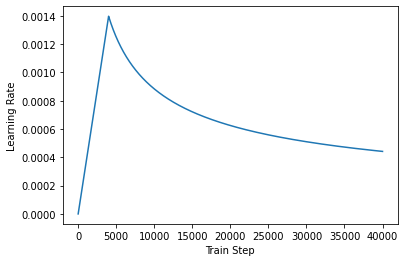

In [15]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(hyper_params["d_model"])

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

temp_learning_rate_schedule = CustomSchedule(hyper_params["d_model"])

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")



# Loss and metrics

In [16]:
#TODO: TRaining

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

# Training Checkpointing

In [17]:
hyper_params = {
    "nb_encoder_layers": 2, #nombre de couches encodeur dans la partie encodeur
    "nb_decoder_layers": 2, #nombre de couches encodeur dans la partie decodeur
    "d_model": 128, #profondeur de modèle
    "dff": 512, #taille de vecteur
    "nb_heads": 8, #nombre de têtes d'attention 
    "rate": 0.1, # pourcentage de dropout
    "input_size": 8500, #nombre de tokens en entrée
    "target_size": 8000, #nombre de tokens predictables
    "pe_input": 10000,
    "pe_target": 10000,
}

transformer = Transformer(hyper_params)

def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

##Checkpoint Creation


In [18]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

## Training

In [19]:
EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = inp[:, :-1]
  tar_real = inp[:, :-1]

  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

  with tf.GradientTape() as tape:
    predictions, _ = transformer(inp, tar_inp,
                                 True,
                                 enc_padding_mask,
                                 combined_mask,
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese
  for (batch, inp) in enumerate(train_batches):
    train_step(inp)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Model: "transformer_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  1484544   
_________________________________________________________________
decoder_1 (Decoder)          multiple                  1553152   
_________________________________________________________________
dense_65 (Dense)             multiple                  1032000   
Total params: 4,069,696
Trainable params: 4,069,696
Non-trainable params: 0
_________________________________________________________________


ValueError: Structure of Python function inputs does not match input_signature:
  inputs: (
    tf.Tensor([b'172.16.0.5' b'58445' b'192.168.50.1' b'4463' b'17'], shape=(5,), dtype=string))
  input_signature: (
    TensorSpec(shape=(None, None), dtype=tf.int64, name=None),
    TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

# Evaluate

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=68a2f52b-2852-47bd-99e2-b4dcf1b1d8cc' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>